In [1]:
from large_gcs.example_graphs.spp_gcs import create_spp_2d_graph
from large_gcs.graph.cost_factory import create_l2norm_edge_cost, create_l2norm_squared_edge_cost
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Optional, Union
import numpy as np
import random
from copy import deepcopy
from dataclasses import dataclass
from large_gcs.graph.graph import Graph, DefaultGraphCostsConstraints, Edge, Vertex
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from large_gcs.graph.graph import Graph
from large_gcs.geometry.point import Point
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.geometry.ellipsoid import Ellipsoid


Setting random seed to 860705


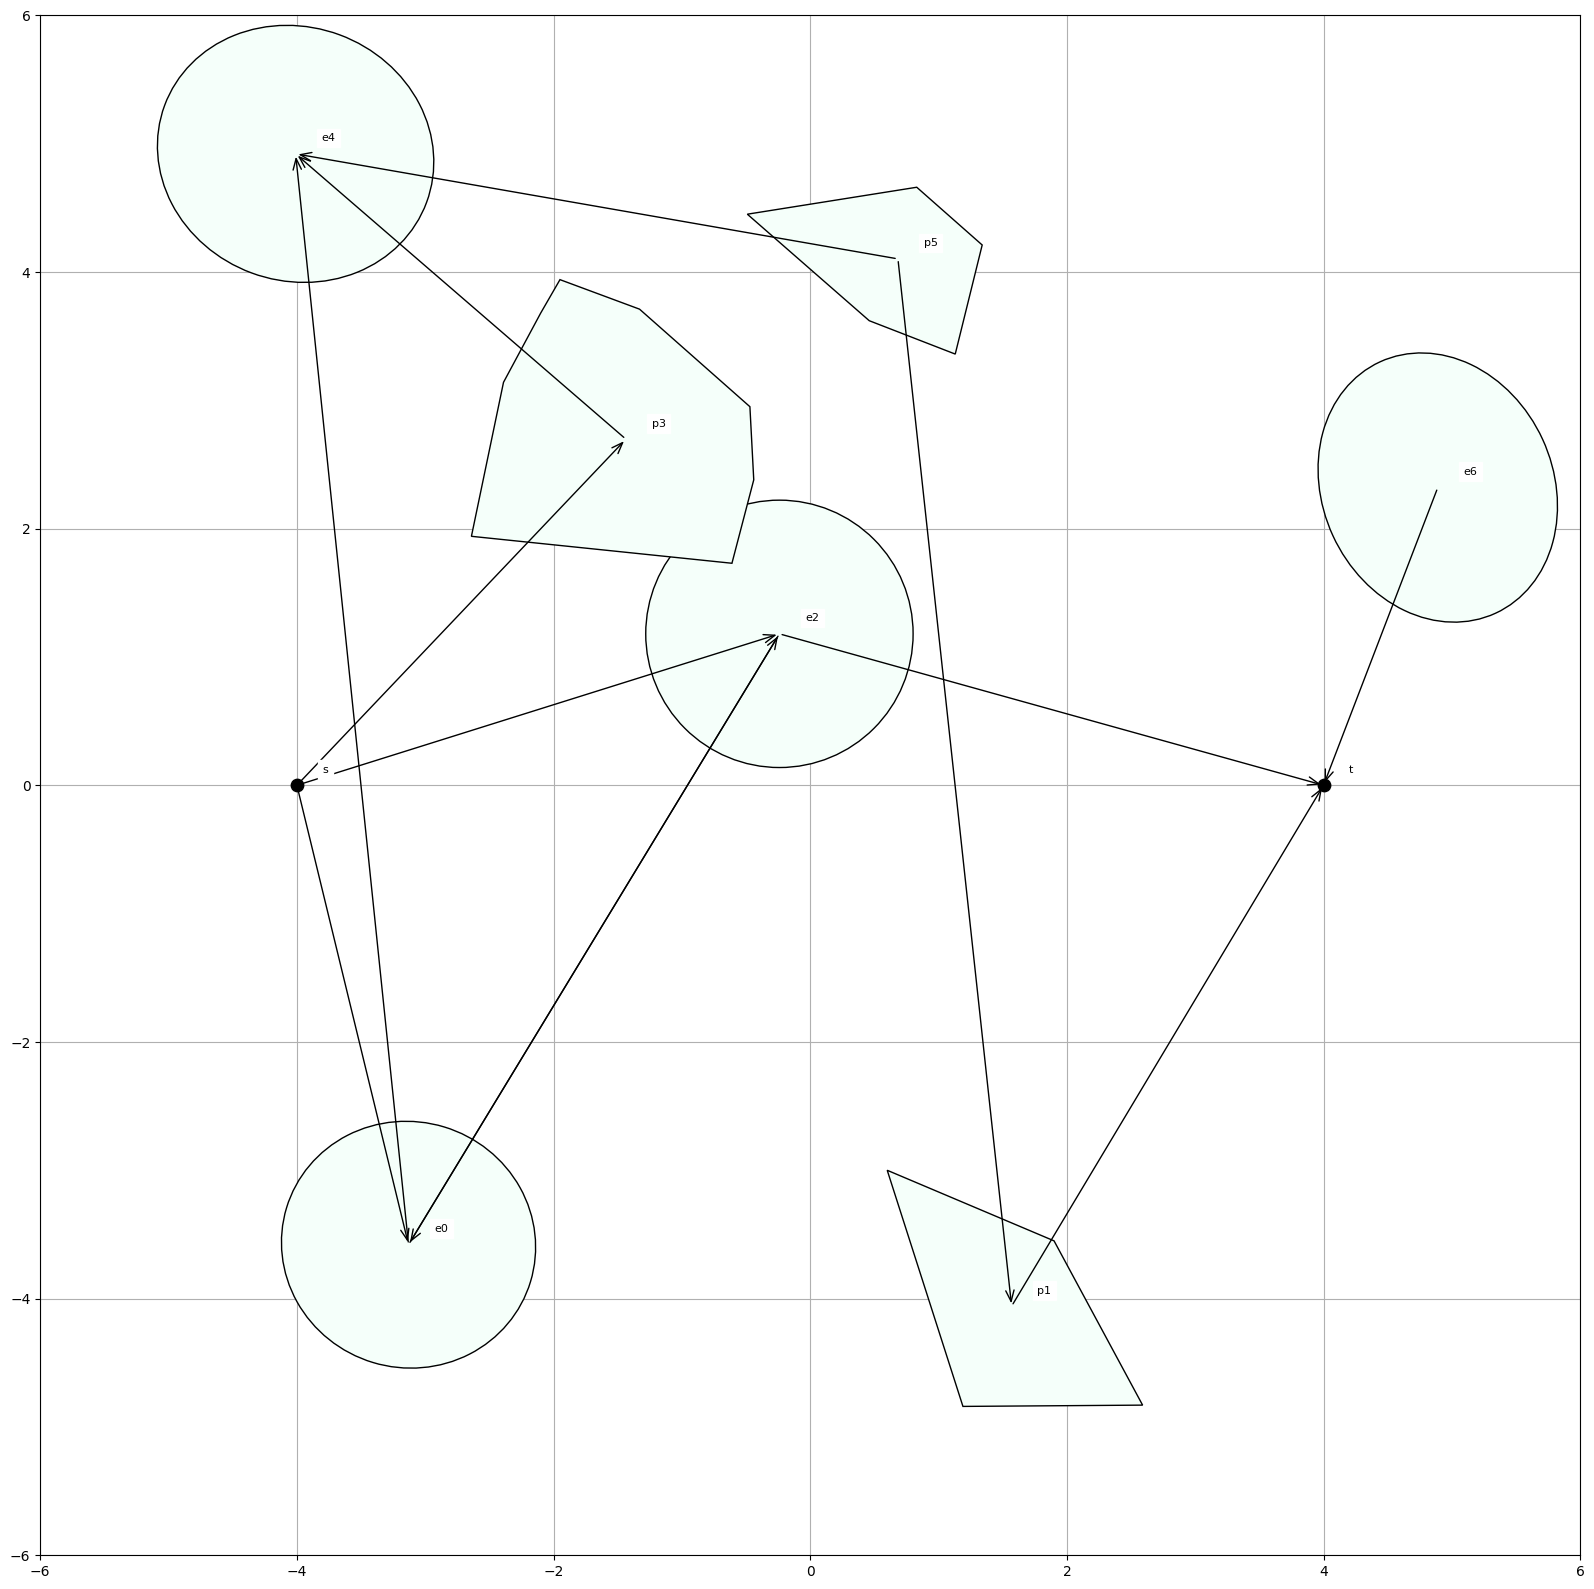

In [6]:
@dataclass
class SppShapeGcsGeneratorParams:
    dim: int = 2
    n_sets: int = 7
    source: Tuple = (-4,0)
    target: Tuple = (4,0)
    n_st_edges: int = 3
    workspace: List = ([-5, 5], [-5, 5])
    set_scale: float = 1.2
    k_nearest_edges: Tuple[int, int] = (0,4)
    k_nearest_pool: int = 10
    n_polyhedron_vertices: Tuple[int, int] = (4,20)
    random_seed: int = None
    save_path: str = "spp_shape_gcs.npy"
    should_save: bool = False

# params = SppShapeGcsGeneratorParams(
#     n_sets=100,
#     workspace=([-25, 25], [-25, 25]),
#     set_scale=1.2,
#     k_nearest_edges=(2,4),
#     k_nearest_pool=20,
#     random_seed=490052
# )

params = SppShapeGcsGeneratorParams(should_save=True)

def generate_spp_shape_gcs(params: SppShapeGcsGeneratorParams) -> Graph:
    if params.random_seed:
        np.random.seed(params.random_seed)
    else:
        seed = np.random.randint(0, 1000000)
        print(f"Setting random seed to {seed}")
        params.random_seed = seed
        np.random.seed(seed)
    params.workspace = np.array(params.workspace)
    round_dp = 2
    # Uniformly sample n_sets within the dim dimensional workspace
    points = np.round(
                np.random.uniform(params.workspace[:, 0],
                                  params.workspace[:, 1],
                                  (params.n_sets, params.dim))
            ,round_dp)

    # 2) Sort the sampled points by l2 norm distance away from the bottom left corner of the workspace
    dists = np.linalg.norm(points - params.workspace[:, 0], axis=1)
    sorted_indices = np.argsort(dists)
    points = points[sorted_indices]

    # Initialize the graph
    graph = Graph()
    
    polyhedra = {}
    ellipsoids = {}
    edges = {}
    # For each point, randomly choose if it's going to be a polyhedron or an ellipse
    for i, point in enumerate(points):
        if np.random.choice([True, False]):
            Q, _ = np.linalg.qr(np.random.randn(params.dim, params.dim))  # Random orthogonal matrix
            # Diagonal matrix with entries normally distributed around 1 * set_scale
            D = np.diag(np.abs(np.random.normal(1, 0.3, params.dim))) / params.set_scale
            A = Q @ D @ Q.T
            A = np.round(A, round_dp)
            shape = Ellipsoid(center=point, A=A)
            vertex_name = f"e{i}"
            ellipsoids[vertex_name] = (point, A)
        else:
            # Create a polyhedron
            n_vertices = np.random.randint(params.n_polyhedron_vertices[0], params.n_polyhedron_vertices[1] + 1)
            vertices = np.round(point + np.random.uniform(-1, 1, (n_vertices, params.dim)) * params.set_scale, round_dp)
            hull = ConvexHull(vertices)  # orders vertices counterclockwise
            vertices = vertices[hull.vertices]
            shape = Polyhedron(vertices=vertices)
            vertex_name = f"p{i}"
            polyhedra[vertex_name] = vertices

        # Add the vertex to the graph
        v = Vertex(shape)
        graph.add_vertex(v, vertex_name)
    
    

    # Add edges to nearby vertices
    dist_matrix = cdist(points, points)
    for i, u in enumerate(graph.vertex_names):
        nearest_indices = np.argsort(dist_matrix[i])[:params.k_nearest_pool]
        n_edges = np.random.randint(params.k_nearest_edges[0], params.k_nearest_edges[1])
        vs = []
        for j in np.random.choice(nearest_indices, n_edges):
            v = graph.vertex_names[j]
            graph.add_edge(Edge(u,v))
            vs.append(v)
        edges[u] = vs
    
    # Add source and target vertices
    graph.add_vertex(Vertex(Point(params.source)), "s")
    graph.add_vertex(Vertex(Point(params.target)), "t")
    # Add edges from source and target to nearby vertices
    dist_matrix = cdist(np.array([params.source, params.target]), points)
    nearest_source_indices = np.argsort(dist_matrix[0])[:params.n_st_edges]
    vs = []
    for i in nearest_source_indices:
        v = graph.vertex_names[i]
        graph.add_edge(Edge("s", v))
        vs.append(v)
    edges["s"] = vs
    nearest_target_indices = np.argsort(dist_matrix[1])[:params.n_st_edges]
    for i in nearest_target_indices:
        u = graph.vertex_names[i]
        graph.add_edge(Edge(u, "t"))
        edges[u].append("t")

    if params.should_save:
        np.save(params.save_path, {
            "polyhedra": polyhedra,
            "ellipsoids": ellipsoids,
            "edges": edges,
            "params": params,
        })

    return graph

G = generate_spp_shape_gcs(params)

# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
plt.grid()
plt.xlim(params.workspace[0]* 1.2)
plt.ylim(params.workspace[1]* 1.2)
plt.show()

{'polyhedra': {'p1': array([[ 0.6 , -3.  ],
       [ 1.19, -4.84],
       [ 2.59, -4.83],
       [ 1.9 , -3.55]]), 'p3': array([[-2.64,  1.94],
       [-0.61,  1.73],
       [-0.44,  2.38],
       [-0.47,  2.95],
       [-1.33,  3.71],
       [-1.95,  3.94],
       [-2.1 ,  3.68],
       [-2.39,  3.14]]), 'p5': array([[ 1.13,  3.36],
       [ 1.34,  4.21],
       [ 0.83,  4.66],
       [-0.49,  4.45],
       [ 0.46,  3.62]])}, 'ellipsoids': {'e0': (array([-3.13, -3.58]), array([[1.01, 0.01],
       [0.01, 1.04]])), 'e2': (array([-0.24,  1.18]), array([[0.96, 0.  ],
       [0.  , 0.96]])), 'e4': (array([-4.01,  4.92]), array([[0.93, 0.03],
       [0.03, 1.  ]])), 'e6': (array([4.89, 2.32]), array([[1.08, 0.07],
       [0.07, 0.96]]))}, 'edges': {'e0': ['e0', 'e2', 'e4'], 'p1': ['t'], 'e2': ['e0', 't'], 'p3': ['e4'], 'e4': [], 'p5': ['p5', 'p1', 'e4'], 'e6': ['t'], 's': ['e0', 'p3', 'e2']}, 'params': SppShapeGcsGeneratorParams(dim=2, n_sets=7, source=(-4, 0), target=(4, 0), n_st_edges=3,

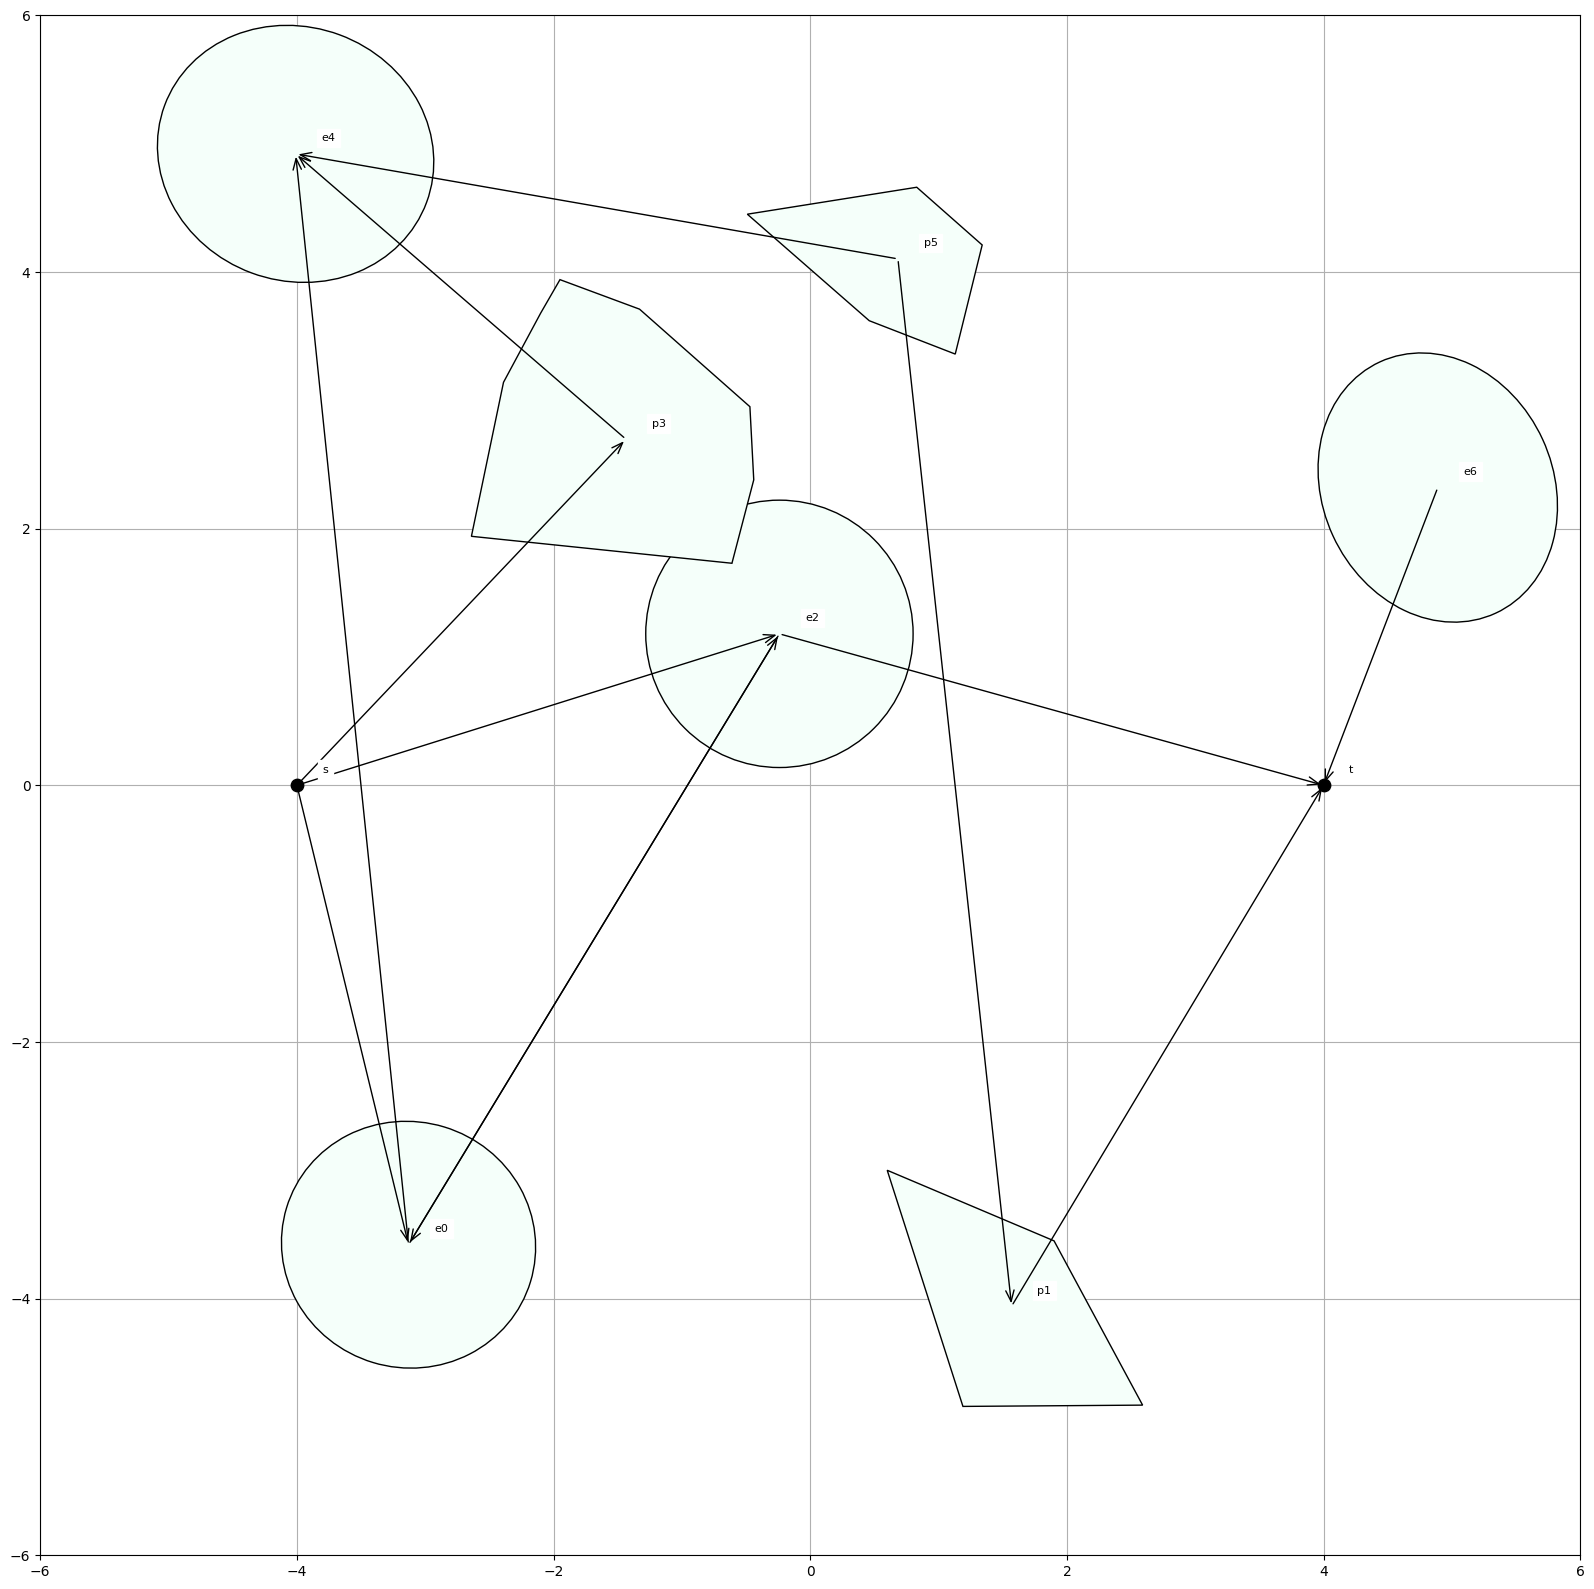

In [7]:
data = np.load(params.save_path, allow_pickle=True)
print(data)
def load_spp_shape_gcs(path: str) -> Graph:
    data = np.load(path, allow_pickle=True)
    polyhedra = data["polyhedra"].item()
    ellipsoids = data["ellipsoids"].item()
    edges = data["edges"].item()
    params = data["params"].item()
    graph = Graph()
    graph.add_vertex(Vertex(Point(params.source)), "s")
    graph.add_vertex(Vertex(Point(params.target)), "t")
    for vertex_name, (point, A) in ellipsoids.items():
        shape = Ellipsoid(center=point, A=A)
        graph.add_vertex(Vertex(shape), vertex_name)
    for vertex_name, vertices in polyhedra.items():
        shape = Polyhedron(vertices=vertices)
        graph.add_vertex(Vertex(shape), vertex_name)
    for u, vs in edges.items():
        for v in vs:
            graph.add_edge(Edge(u,v))
    return graph

# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
plt.grid()
plt.xlim(params.workspace[0]* 1.2)
plt.ylim(params.workspace[1]* 1.2)
plt.show()

In [ ]:
# Create an ellipse
Q, _ = np.linalg.qr(np.random.randn(params.dim, params.dim))  # Random orthogonal matrix
D = np.diag(np.abs(np.random.normal(1, 0.3, params.dim))) * 1/params.set_scale  # Diagonal matrix with entries normally distributed around 1
A = Q @ D @ Q.T
shape = Ellipsoid(center=[0,0], A=A)
plt.xlim([-5,5])
plt.ylim([-5,5])
shape.plot()


1. **Generate a random orthogonal matrix `Q`.**

   An orthogonal matrix is a square matrix whose columns and rows are orthogonal unit vectors (i.e., orthonormal vectors). This means that its transpose is also its inverse, and that the dot product of different rows (or, equivalently, columns) is zero, while the dot product of a row with itself is 1.

   One way to generate a random orthogonal matrix is to generate a matrix with random elements, and then perform QR decomposition on it. QR decomposition is a process that takes a matrix and decomposes it into an orthogonal matrix `Q` and an upper triangular matrix `R`.

   In the code, `np.linalg.qr(np.random.randn(params.dim, params.dim))` generates a random matrix with dimensions `params.dim` by `params.dim`, and then performs QR decomposition on it. The function `np.linalg.qr` returns two matrices, `Q` and `R`, but we only need `Q`, so we ignore `R` with `_`.

2. **Generate a diagonal matrix `D` with positive entries that are normally distributed around 1.**

   A diagonal matrix is a matrix in which the entries outside the main diagonal are all zero. The main diagonal entries are the lengths of the axes of the ellipse.

   In the code, `np.diag(np.abs(np.random.normal(1, 0.1, params.dim)))` generates a diagonal matrix where the diagonal entries are drawn from a normal distribution with mean 1 and standard deviation 0.1. The `np.abs` function ensures that these entries are positive. The function `np.random.normal` generates normally distributed random numbers, and `np.diag` creates a diagonal matrix from these numbers.

3. **Compute `A = Q @ D @ Q.T`.**

   This step creates the matrix `A` that defines the ellipse. The matrix `A` is a positive definite matrix, which means that for any non-zero vector `x`, the quantity `xᵀAx` is positive. This property ensures that the equation `(x-center)ᵀAᵀA(x-center) ≤ 1` defines an ellipse.

   The matrix `A` is computed as the product of `Q`, `D`, and the transpose of `Q`. This ensures that `A` is positive definite, because `D` is a diagonal matrix with positive entries (which makes it positive definite), and `Q` is an orthogonal matrix (which preserves the positive definiteness when it's multiplied on the left and its transpose is multiplied on the right).

   The orthogonal matrix `Q` effectively rotates the coordinate system, which results in the ellipse being randomly oriented in space. The diagonal matrix `D` scales the axes of the ellipse, which results in the ellipse having random axis lengths.

## Why does making the values of D smaller, make the ellipse larger?

The matrix `D` in this context is a diagonal matrix that scales the axes of the ellipse. The values on the diagonal of `D` represent the lengths of the semi-axes of the ellipse. 

The equation of an ellipse centered at the origin in matrix form is given by:

$$
x^T A x = 1
$$

where `x` is a vector representing a point in space, and `A` is a positive definite matrix. If `A` is a diagonal matrix, then the equation represents an axis-aligned ellipse, and the diagonal elements of `A` are the reciprocals of the squares of the semi-axis lengths.

So, if the values in `D` (and hence in `A`) are smaller, the lengths of the semi-axes of the ellipse are larger, making the ellipse itself larger. Conversely, if the values in `D` are larger, the lengths of the semi-axes are smaller, making the ellipse smaller.

In the context of the code, the matrix `A` is not necessarily diagonal because it's computed as `Q @ D @ Q.T`, which represents a rotated and scaled ellipse. However, the principle remains the same: smaller values in `D` result in larger ellipses, and larger values in `D` result in smaller ellipses.